# Estimating the energy of a low frequency signal with low-pass filtering

We are interested in computing the energy of a variable $u$ which because it may coexist with higher frequency motions need to be low-pass filtered (filtered variable is denoted $\bar u$).
The energy of the low-frequency signal is then estimated to be:

$
\begin{align}
E &= \big \langle \bar u^2 \big \rangle
\end{align}
$

- Figure: sensitbilité (biais, variance) à la fréquence de coupure du filtre pass-bas vs échelle de temps de décorrelation du signal
- Figure: sensibilité à la quantité de données disponibles
- Figure: sensibilité au sous-sampling (variance préservée)

### references (!to be updated!):

- Bendat and Piersol: *J. S. Bendat and A. G. Piersol. Random Data: Analysis and Measurement Procedures. Wiley series in probability and statistics. Wiley-Interscience, 3rd edition, 2000.*
- Bailey and Hammersley 1946 - general timeseries, sample mean and variance : *G. Bayley and J. Hammersley. The” effective” number of independent observations in an autocorrelated time series. Supplement to the Journal of the Royal Statistical Society, 8(2):184–197, 1946.*
- Zieba 2010: *A. Zieba. Effective number of observations and unbiased estimators of variance for autocorrelated data-an overview. Metrology and Measurement Systems, (1), 2010.*
- Barlett 1946 - long time series, autocorrelations: *M. S. Bartlett. On the theoretical specification and sampling properties of autocorrelated time-series. Supplement to the Journal of the Royal Statistical Society, 8(1):27–41, 1946.*
- Chelton 1983 - multivariate case, cross-correlations: *D. B. Chelton. Effects of sampling errors in statistical estimation. Deep Sea Research Part A. Oceano- graphic Research Papers, 30(10):1083–1103, 1983.*

---
## generate synthetic data

Generate a 100 day time series with an exponential autocorrelation and a 10 days decorrelation timescale

In [1]:
import xarray as xr
import numpy as np

from scipy import stats                                                         

import matplotlib.pyplot as plt
import seaborn as sns

import sstats.tseries as ts
import sstats.sigp as sigp
import sstats.hfreq as hf

# dev
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
# https://www.wrighters.io/using-autoreload-to-speed-up-ipython-and-jupyter-work/
%reload_ext autoreload
%autoreload 1
#%aimport sstats
%aimport sstats

In [6]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#w = cluster.scale(jobs=2)
#
client = Client(cluster)

Input parameters:

In [2]:
mu=0 # true mean
sigma0 = 1 # true variance
T = 10 # days, decorrelation timescale, base case
dt = 1/24 # hours, sampling interval

# filter properties:
filter_cutoff = 0.5 # cpd
filter_size = 20 # in days
filter_size_pts = int(20/dt) # in points

print(f"Default filter cutoff frequency and window size: {filter_cutoff}cpd , {filter_size_pts} points = {filter_size} days ")

Default filter cutoff frequency and window size: 0.5cpd , 480 points = 20 days 


In [3]:
def generate_filter(band, T=10, dt=1/24, lat=None, bandwidth=None, normalized_bandwidth=None):
    """Wrapper around scipy.signal.firwing
    
    Parameters
    ----------
    band: str, float
        Frequency band (e.g. "semidiurnal", ...) or filter central frequency
    T: float
        Filter length in days
    dt: float
        Filter/time series time step
    lat: float
        Latitude (for inertial band)
    bandwidth: float
        Filter bandwidth in cpd
    dt: float
        hours
    """
    numtaps = int(T*24)    
    pass_zero = False
    #
    if band == "subdiurnal":
        pass_zero = True
        cutoff = [1.0 / 2.0]    
    elif band == "semidiurnal":
        omega = 1.9322 #  M2 24/12.4206012 = 1.9322
    elif band == "diurnal":
        omega = 1. # K1 24/23.93447213 = 1.0027
    elif band == "inertial":
        try:
            omega = coriolis(lat) * 3600 / 2.0 / np.pi
        except:
            print("latitude needs to be provided to generate_filter")
    elif isinstance(band, float):
        omega = band
    #
    if bandwidth is not None:
        cutoff = [omega - bandwidth, omega + bandwidth]
    elif normalized_bandwidth is not None:
        cutoff = [omega * (1 - normalized_bandwidth), 
                  omega * (1.0 + normalized_bandwidth),
                 ]
    elif band != "subdiurnal":
        print("bandwidth or normalized_bandwidth needs to be provided")
    #
    h = signal.firwin(
        numtaps, cutoff=cutoff, pass_zero=pass_zero, fs=1/dt, scale=True
    )
    return h

def filter_response(h, dt=1/24):
    """Returns the frequency response"""
    w, hh = signal.freqz(h, worN=8000, fs=1/dt)
    return hh, w

def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}




In [4]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}



tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth

print('omega M2:%s'%omega_M2)
print('omega S2:%s'%omega_S2)
print('omega N2:%s'%omega_N2)
print('omega K2:%s'%omega_K2)

omega M2:1.9322736142672448
omega S2:2.0
omega N2:1.8959819677542018
omega K2:2.0054758185413344


In [5]:
import scipy.signal as signal
dband = [0.1,0.2,0.3] #0.05,
h,h_hat,w = {},{},{}
for d in dband:
    h[str(d)] = generate_filter(omega, T=Tw, dt=dt, bandwidth=d, normalized_bandwidth=None)
    h_hat[str(d)], w[str(d)] = filter_response(h[str(d)], dt)

In [6]:
filter_h, filter_t = sigp.lowpass_filter(filter_cutoff, filter_size_pts, dt)
h_hat, w = sigp.filter_response(filter_h, dt)

In [7]:
# total number of points
#N = ds.time.size # = delta_T/dt 

#effective_DOF(sigma, dt, N)
#print("mean - DOF (Neff):")
#print(f"  exact: {Neff_exact:.1f}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


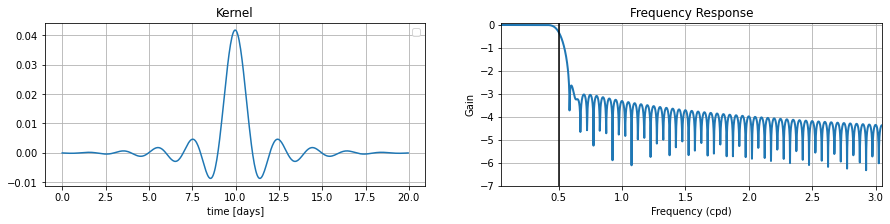

In [8]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
ax.plot(filter_t, filter_h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(filter_cutoff, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [9]:
def generate_timeseries(delta_T, n_draws, T, sigma0, filtering=True, seed=0, chunks=dict(T=-1)):
    u = mu + ts.exp_autocorr((delta_T, dt), T, 
                             np.sqrt(sigma0), 
                             burnin=int(10*T_all[-1]/dt),
                             draws=n_draws,
                             seed=0,
                             chunks=chunks,
                            )
    ds = u.rename("u").to_dataset()
    # low-pass filter
    if filtering:
        ds["u_bar"] = sigp.filt(ds.u, filter_h)    
    return ds

---

## filter timer series and look at an overview

In [10]:
delta_T = 500 # time series length in days
n_draws = 10 # number of draws
T_all = [0.5*T, T, 2*T,4*T]
dt = 1/24 # time step in days
rad = 2*np.pi
i,j = 1,2
ds_hf = {}
for c,om in zip(['M2','S2'],[omega_M2,omega_S2]):
    ds_hf_real = generate_timeseries(delta_T, n_draws, T_all, sigma0, filtering=False,seed=i)
    ds_hf_imag = generate_timeseries(delta_T, n_draws, T_all, sigma0, filtering=False,seed=j)
    ds_hf[c] = (ds_hf_real/np.sqrt(2)*np.exp(1j*om*rad*ds_hf_real['u'].time)+1j*ds_hf_imag/np.sqrt(2)*np.exp(1j*(om*rad)*ds_hf_real['u'].time)).u
    ds_hf[c] = ds_hf[c].chunk({'time':-1,'draw':-1,'T':-1})
    i+=2
    j+=2
ds_hf

{'M2': <xarray.DataArray 'u' (T: 4, time: 12000, draw: 10)>
 dask.array<add, shape=(4, 12000, 10), dtype=complex128, chunksize=(4, 12000, 10), chunktype=numpy.ndarray>
 Coordinates:
   * T        (T) float64 5.0 10.0 20.0 40.0
   * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
   * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9,
 'S2': <xarray.DataArray 'u' (T: 4, time: 12000, draw: 10)>
 dask.array<add, shape=(4, 12000, 10), dtype=complex128, chunksize=(4, 12000, 10), chunktype=numpy.ndarray>
 Coordinates:
   * T        (T) float64 5.0 10.0 20.0 40.0
   * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
   * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9}

In [11]:
sigma = [0.01,0.1,1.,2.]
for c,om in zip(['M2','S2'],[omega_M2,omega_S2]):
    ds_hf[c] = xr.concat([np.sqrt(u)*ds_hf[c] for u in sigma],dim='rms').assign_coords({'rms':sigma})
    ds_hf[c+'_coh'] = xr.concat([np.sqrt(u)*np.exp(1j*om*rad*ds_hf_real['u'].time
                                                  ) for u in sigma],dim='rms').assign_coords({'rms':sigma})

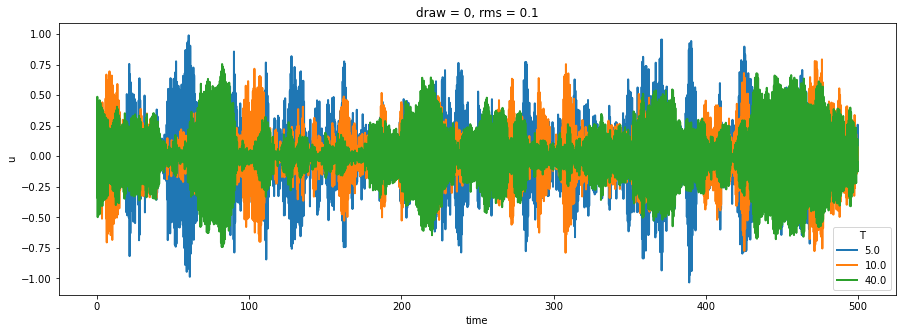

In [12]:
_ds = ds_hf['M2'].sel(draw=0, T=[T_all[0], T,  T_all[-1]],rms=0.1, method="nearest")

fig, ax = plt.subplots(1,1, figsize=(15,5))
_ds.real.plot.line(x="time", lw=2)


(100.0, 150.0)

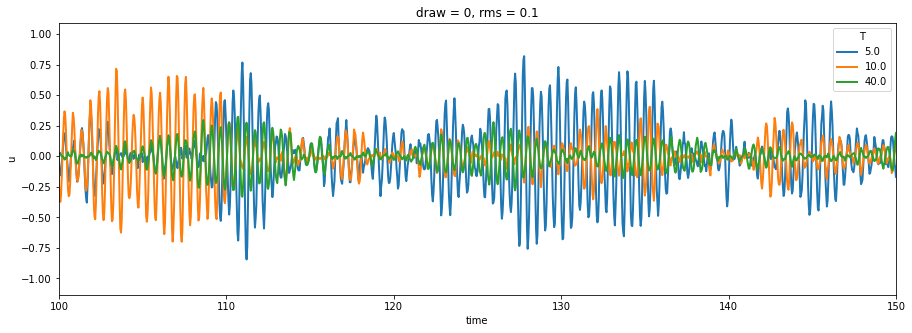

In [13]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
_ds.real.plot.line(x="time", lw=2)
#_ds.u_bar.plot.line(x="time", color="0.5", add_legend=False)
ax.set_xlim(100,150)

In [14]:
ds_hf['high_MS'] = ds_hf['M2']+ds_hf['S2']
ds_hf['high_MS_coh'] = ds_hf['M2_coh']+ds_hf['S2_coh']
ds_hf['M2_mix'] = ds_hf['M2']/np.sqrt(2)+ds_hf['M2_coh']/np.sqrt(2)
ds_hf['S2_mix'] = ds_hf['S2']/np.sqrt(2)+ds_hf['S2_coh']/np.sqrt(2)
ds_hf['high_MS_mix'] = ds_hf['M2_mix']+ds_hf['S2_mix']

In [15]:
exp_M2_demod = np.exp(-1j*omega_M2*rad*ds_hf['M2'].time)
exp_S2_demod = np.exp(-1j*omega_S2*rad*ds_hf['S2'].time)
exp_MS_demod = np.exp(-1j*omega*rad*ds_hf['S2'].time)

In [16]:
import scipy.signal as signal
p = '_coh'
for c,exp in zip(['M2','S2','high_MS'],[exp_M2_demod,exp_S2_demod,exp_MS_demod]):
    ds_hf[c+p+'_analytical'] = xr.DataArray(signal.hilbert(ds_hf[c+p].real)
                                            ,coords={"rms":sigma,"time":ds_hf['M2'].time})
    #    ds_hf[c+p+'_analytical'] = ds_hf[c+p].real+
    ds_hf[c+p+'_demodulated'] = ds_hf[c+p]*exp
    ds_hf[c+p+'_demodulated_bis'] = ds_hf[c+p+'_analytical']*exp
    
#p = '_coh'
for c,exp in zip(['M2','S2','high_MS'],[exp_M2_demod,exp_S2_demod,exp_MS_demod]):
    for p in ['_mix','']:
        ds_hf[c+p+'_analytical'] = xr.DataArray(signal.hilbert(ds_hf[c+p].real),
                                                coords={"rms":sigma,"T":T_all,
                                                        "time":ds_hf['M2'].time,
                                                        "draw":ds_hf['M2'].draw})

        ds_hf[c+p+'_demodulated'] = ds_hf[c+p]*exp
        ds_hf[c+p+'_demodulated_bis'] = ds_hf[c+p+'_analytical']*exp

In [17]:
ds_M2 = xr.Dataset({'M2'+c :xr.concat([ds_hf['M2'+p+c].rename('M2') for p in ['_coh','_mix','']],
               dim='signal').assign_coords({'signal':['coherent','mixed','incoherent']}
                                        )  for c in ['','_demodulated','_demodulated_bis','_analytical']}).persist()
ds_S2 = xr.Dataset({'S2'+c :xr.concat([ds_hf['S2'+p+c].rename('M2') for p in ['_coh','_mix','']],
               dim='signal').assign_coords({'signal':['coherent','mixed','incoherent']}
                                        )  for c in ['','_demodulated','_demodulated_bis','_analytical']}).persist()
ds_MS = xr.Dataset({'MS'+c :xr.concat([ds_hf['high_MS'+p+c].rename('M2') for p in ['_coh','_mix','']],
               dim='signal').assign_coords({'signal':['coherent','mixed','incoherent']}
                                        )  for c in ['','_demodulated','_demodulated_bis','_analytical']}).persist()
ds_M2 = ds_M2.chunk({'time':-1,'draw':-1,'T':-1,'signal':-1})
ds_S2 = ds_S2.chunk({'time':-1,'draw':-1,'T':-1,'signal':-1})
ds_MS = ds_MS.chunk({'time':-1,'draw':-1,'T':-1,'signal':-1})

In [18]:
for p in ['','_demodulated','_demodulated_bis']:
    ds_M2['M2'+p+'_real'] = ds_M2['M2'+p].real
    ds_M2['M2'+p+'_imag'] = ds_M2['M2'+p].imag
    ds_S2['S2'+p+'_real'] = ds_S2['S2'+p].real
    ds_S2['S2'+p+'_imag'] = ds_S2['S2'+p].imag
    ds_MS['MS'+p+'_real'] = ds_MS['MS'+p].real
    ds_MS['MS'+p+'_imag'] = ds_MS['MS'+p].imag

In [19]:
ds = xr.merge([ds_M2,ds_S2,ds_MS]).persist()

In [20]:
_ds = ds[['M2','S2','MS']] #,'total_M2','total_MS'

In [21]:
ds_filtered_M2 = xr.concat([sigp.bpass_demodulate(xr.Dataset(data_vars = {'M2':_ds['M2']}).real,omega_M2,dband,30
                                                 )[0] for dband in [0.1,0.2,0.3]], dim= 'bandwidth'
                          ).assign_coords({'bandwidth':[0.2,0.4,0.6]}).persist()

In [54]:
ds_filtered_S2 = xr.concat([sigp.bpass_demodulate(xr.Dataset(data_vars = {'S2':_ds['S2']}).real,omega_S2,dband,30
                                                 )[0] for dband in [0.1,0.2,0.3]], dim= 'bandwidth'
                          ).assign_coords({'bandwidth':[0.2,0.4,0.6]}).persist()

In [22]:
ds_filtered_MS = xr.concat([sigp.bpass_demodulate(xr.Dataset(data_vars = {'MS':_ds['MS']}).real,omega,dband,30
                                                 )[0] for dband in [0.1,0.2,0.3]], dim= 'bandwidth'
                          ).assign_coords({'bandwidth':[0.2,0.4,0.6]}).persist()

In [23]:
ds_filtered_MS

,Array,Chunk
Bytes,131.84 MiB,10.99 MiB
Shape,"(3, 3, 4, 12000, 4, 10)","(1, 3, 1, 12000, 4, 10)"
Count,12 Tasks,12 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,263.67 MiB,21.97 MiB
Shape,"(3, 3, 4, 4, 10, 12000)","(1, 3, 1, 4, 10, 12000)"
Count,12 Tasks,12 Chunks
Type,complex128,numpy.ndarray
,Array,Chunk


---

## compute the energy (mean square value) of the filtered time series

In [24]:
E = (np.abs(ds[['M2_demodulated','S2_demodulated','MS_demodulated']
              ])**2).mean("time").compute() #, (ds.u_bar**2).mean("time")

E

<xarray.Dataset>
Dimensions:         (T: 4, draw: 10, rms: 4, signal: 3)
Coordinates:
  * T               (T) float64 5.0 10.0 20.0 40.0
  * draw            (draw) int64 0 1 2 3 4 5 6 7 8 9
  * rms             (rms) float64 0.01 0.1 1.0 2.0
  * signal          (signal) <U10 'coherent' 'mixed' 'incoherent'
Data variables:
    M2_demodulated  (signal, rms, T, draw) float64 0.01 0.01 ... 1.588 2.285
    S2_demodulated  (signal, rms, T, draw) float64 0.01 0.01 ... 1.588 2.285
    MS_demodulated  (signal, rms, T, draw) float64 0.01993 0.01993 ... 4.421

In [55]:
E_filt = xr.merge( [(np.abs(ds_filtered_MS['MS_demodulated'])**2).mean("time"),
                    (np.abs(ds_filtered_S2['S2_demodulated'])**2).mean("time"),
                    (np.abs(ds_filtered_M2['M2_demodulated'])**2).mean("time")
                   ]).compute() #, (ds.u_bar**2).mean("time")

E_filt

<xarray.Dataset>
Dimensions:         (T: 4, draw: 10, rms: 4, signal: 3, bandwidth: 3)
Coordinates:
  * T               (T) float64 5.0 10.0 20.0 40.0
  * draw            (draw) int64 0 1 2 3 4 5 6 7 8 9
  * rms             (rms) float64 0.01 0.1 1.0 2.0
  * signal          (signal) <U10 'coherent' 'mixed' 'incoherent'
  * bandwidth       (bandwidth) float64 0.2 0.4 0.6
Data variables:
    MS_demodulated  (bandwidth, signal, rms, T, draw) float64 0.01958 ... 4.317
    S2_demodulated  (bandwidth, signal, rms, T, draw) float64 0.009951 ... 2.258
    M2_demodulated  (bandwidth, signal, rms, T, draw) float64 0.009943 ... 2.258

In [26]:
E

<xarray.Dataset>
Dimensions:         (T: 4, draw: 10, rms: 4, signal: 3)
Coordinates:
  * T               (T) float64 5.0 10.0 20.0 40.0
  * draw            (draw) int64 0 1 2 3 4 5 6 7 8 9
  * rms             (rms) float64 0.01 0.1 1.0 2.0
  * signal          (signal) <U10 'coherent' 'mixed' 'incoherent'
Data variables:
    M2_demodulated  (signal, rms, T, draw) float64 0.01 0.01 ... 1.588 2.285
    S2_demodulated  (signal, rms, T, draw) float64 0.01 0.01 ... 1.588 2.285
    MS_demodulated  (signal, rms, T, draw) float64 0.01993 0.01993 ... 4.421

### Sensitivity to filter

In [50]:
E_filt_mean

<xarray.Dataset>
Dimensions:         (T: 4, rms: 4, signal: 3, bandwidth: 3)
Coordinates:
  * T               (T) float64 5.0 10.0 20.0 40.0
  * rms             (rms) float64 0.01 0.1 1.0 2.0
  * signal          (signal) <U10 'coherent' 'mixed' 'incoherent'
  * bandwidth       (bandwidth) float64 0.2 0.4 0.6
Data variables:
    MS_demodulated  (bandwidth, signal, rms, T) float64 0.01958 ... 3.724
    M2_demodulated  (bandwidth, signal, rms, T) float64 0.009943 ... 1.861

In [56]:
E_mean = E.mean("draw")
E_filt_mean = E_filt.mean("draw")

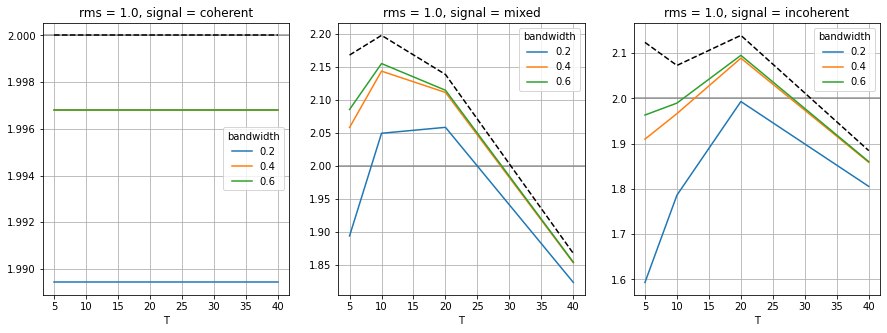

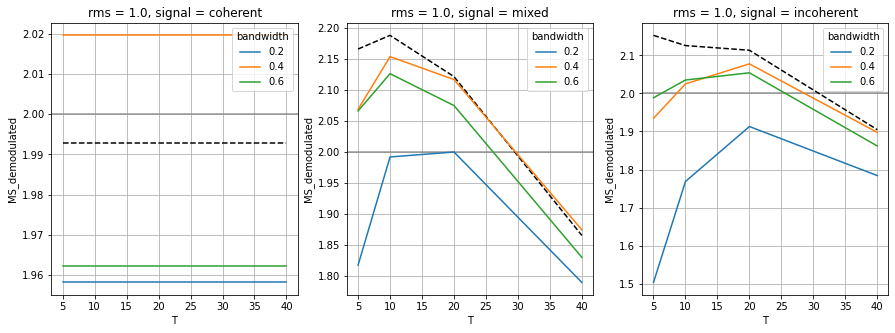

In [74]:
fig,axes =plt.subplots(1,3,figsize=(15,5))
for i,_sig in enumerate(E_mean.signal):
    ax = axes[i]
    ax.axhline(2.,c='grey',alpha=0.8)
    (E_mean.M2_demodulated+E_mean.S2_demodulated).sel(rms=1,signal=_sig).plot(ax=ax,c='k',linestyle='--')
    (E_filt_mean.M2_demodulated+E_filt_mean.S2_demodulated).sel(rms=1,signal=_sig).plot(ax=ax,hue='bandwidth')
    ax.grid()
    
fig,axes =plt.subplots(1,3,figsize=(15,5))
for i,_sig in enumerate(E_mean.signal):
    ax = axes[i]
    ax.axhline(2.,c='grey',alpha=0.8)
    (E_mean.MS_demodulated).sel(rms=1,signal=_sig).plot(ax=ax,c='k',linestyle='--')
    (E_filt_mean.MS_demodulated).sel(rms=1,signal=_sig).plot(ax=ax,hue='bandwidth')
    ax.grid()

### Confidence intervals on energy

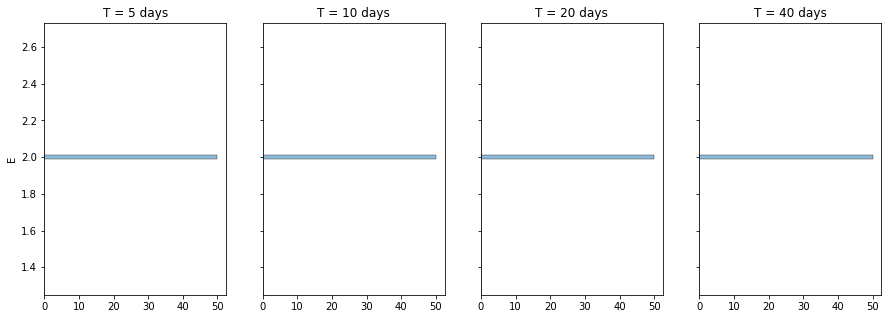

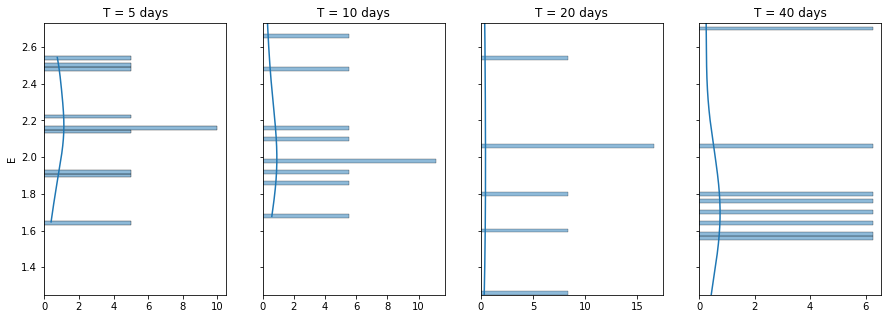

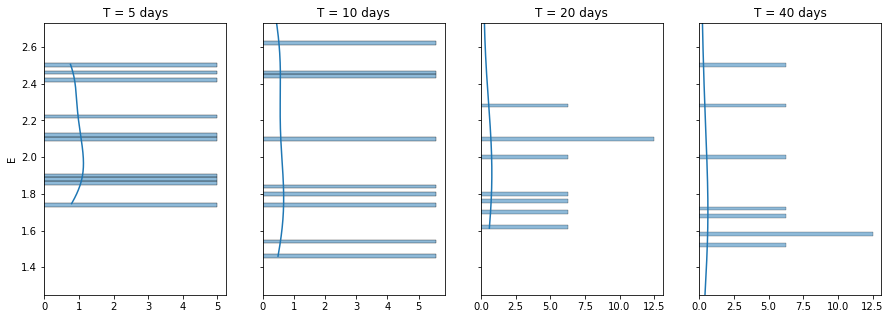

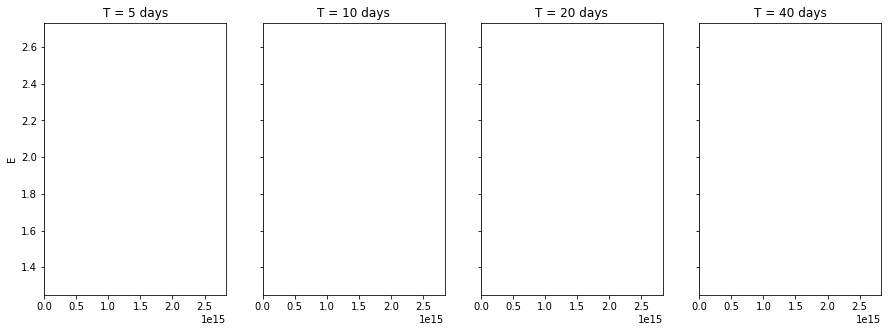

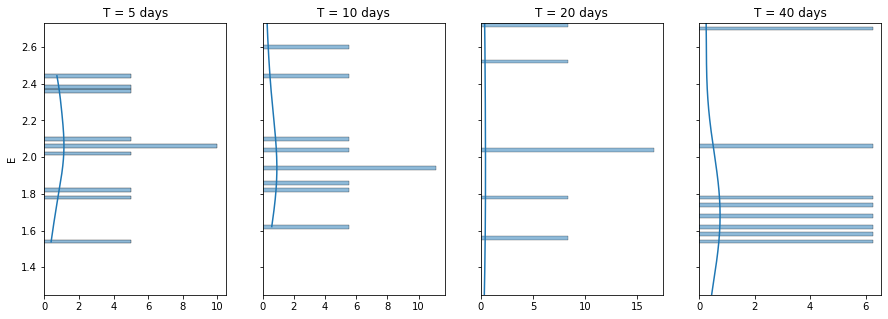

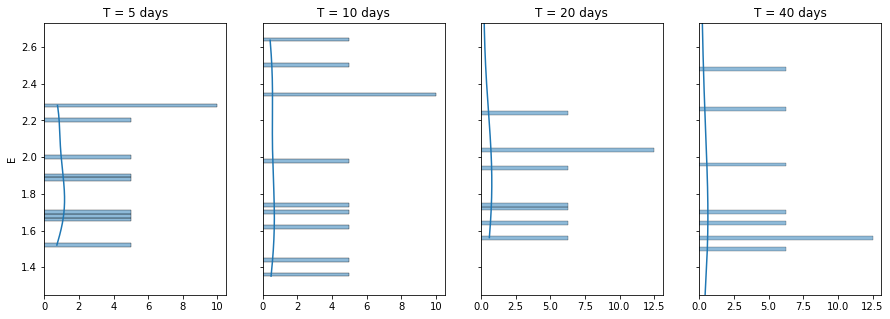

In [79]:
def add_dist(Ne, sigma0, label, color, ax):
    x0, x1 = ax.get_ylim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = E_pdf_expected(x_pdf, float(Ne), float(sigma0))
    ax.plot(y_pdf, x_pdf, color=color, lw=2, label=label)
    #ax.plot(x-y_pdf, x_pdf, color=color, lw=2, label=label)


bins = np.arange(1.25, 2.75, .02)
for _sig in E.signal:
    fig, axes = plt.subplots(1, E.T.size, figsize=(15,5))

    for _T, ax in zip(E.T, axes):
        _E = E.sel(T=_T,rms=1.,signal=_sig)

        ax = sns.histplot(y=(_E.M2_demodulated+_E.S2_demodulated), stat="density", bins=bins, kde=True, ax=ax)
    #    add_dist(_E.Ne_variance, _E.u_bar_theoretical, "expected", "black", ax)
        ax.set_title(f"T = {float(_T):.0f} days")
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_ylim(bins[0], bins[-1])
        if ax!=axes[0]:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("E")
            
            
#bins = np.arange(1.25, 2.75, .02)
for _sig in E_filt.signal:
    fig, axes = plt.subplots(1, E.T.size, figsize=(15,5))

    for _T, ax in zip(E.T, axes):
        _E = E_filt.sel(T=_T,rms=1.,signal=_sig,bandwidth=0.4)

        ax = sns.histplot(y=(_E.M2_demodulated+_E.S2_demodulated), stat="density", bins=bins, kde=True, ax=ax)
    #    add_dist(_E.Ne_variance, _E.u_bar_theoretical, "expected", "black", ax)
        ax.set_title(f"T = {float(_T):.0f} days")
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_ylim(bins[0], bins[-1])
        if ax!=axes[0]:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("E")

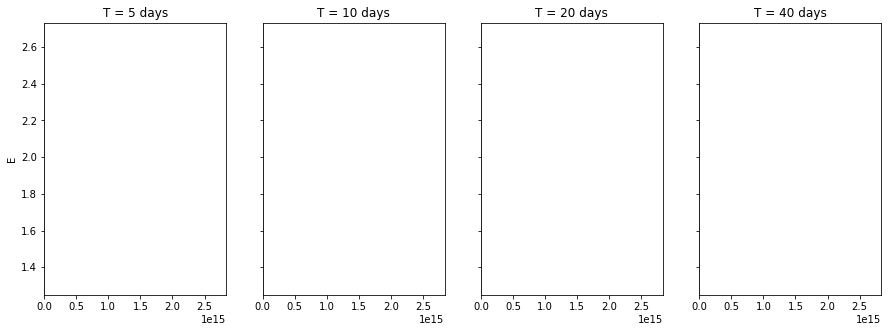

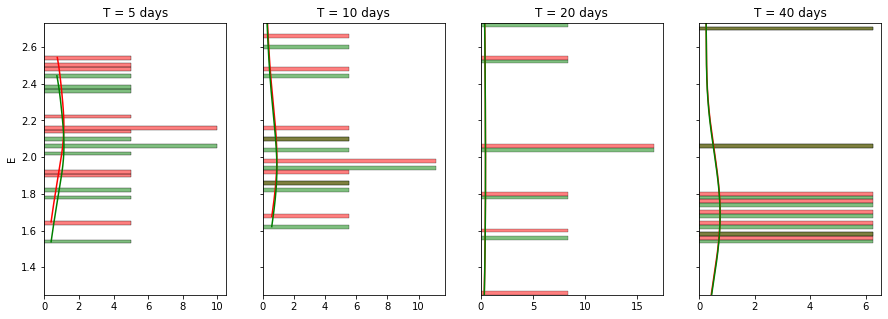

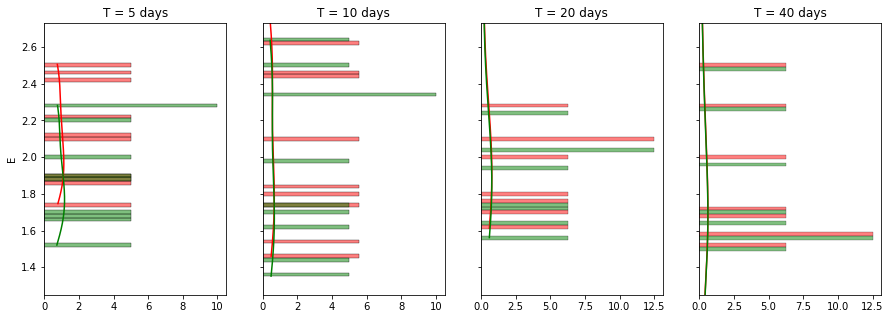

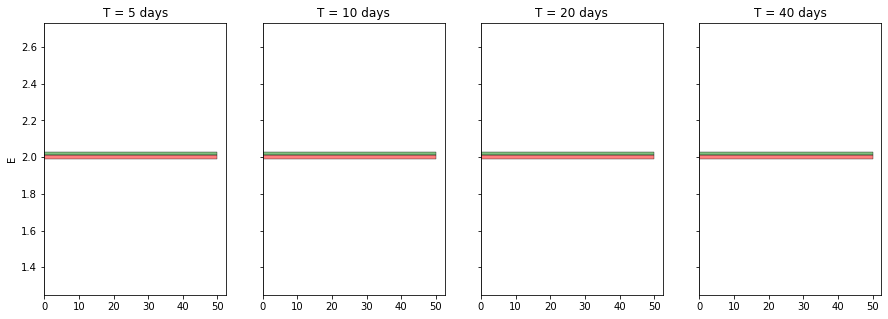

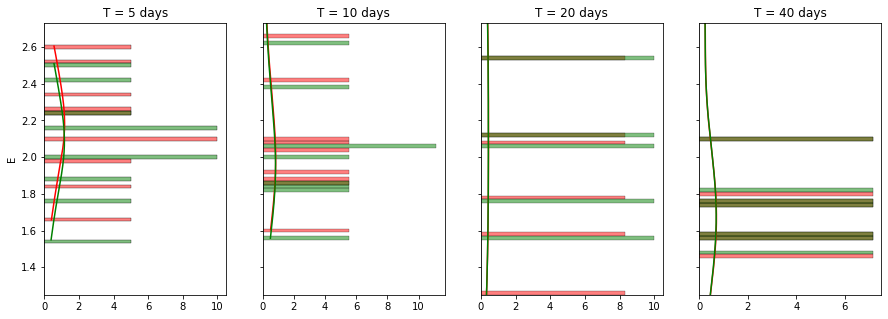

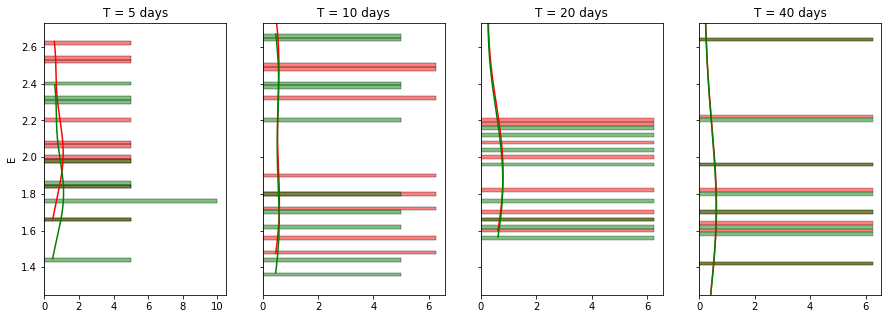

In [94]:
bins = np.arange(1.25, 2.75, .02)
for _sig in E.signal:
    fig, axes = plt.subplots(1, E.T.size, figsize=(15,5))

    for _T, ax in zip(E.T, axes):
        _E_filt = E_filt.sel(T=_T,rms=1.,signal=_sig,bandwidth=0.4)
        _E = E.sel(T=_T,rms=1.,signal=_sig)
        

        ax = sns.histplot(y=(_E.M2_demodulated+_E.S2_demodulated), stat="density", bins=bins, kde=True, ax=ax, color='r')
        sns.histplot(y=(_E_filt.M2_demodulated+_E_filt.S2_demodulated), stat="density", bins=bins, kde=True, ax=ax,color='g')
    #    add_dist(_E.Ne_variance, _E.u_bar_theoretical, "expected", "black", ax)
        ax.set_title(f"T = {float(_T):.0f} days")
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_ylim(bins[0], bins[-1])
#        ax.set_xlim(0,100)
        if ax!=axes[0]:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("E")



bins = np.arange(1.25, 2.75, .02)
for _sig in E.signal:
    fig, axes = plt.subplots(1, E.T.size, figsize=(15,5))

    for _T, ax in zip(E.T, axes):
        _E = E.sel(T=_T,rms=1.,signal=_sig)
        _E_filt = E_filt.sel(T=_T,rms=1.,signal=_sig,bandwidth=0.4)

        ax = sns.histplot(y=(_E.MS_demodulated), stat="density", bins=bins, kde=True, ax=ax, color='r')
        sns.histplot(y=(_E_filt.MS_demodulated), stat="density", bins=bins, kde=True, ax=ax,color='g')
    #    add_dist(_E.Ne_variance, _E.u_bar_theoretical, "expected", "black", ax)
        ax.set_title(f"T = {float(_T):.0f} days")
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_ylim(bins[0], bins[-1])
        
        if ax!=axes[0]:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("E")

In [27]:
from sympy import Symbol, pi, atan, factor, lambdify

In [28]:
u_hf = hf.high_frequency_signal()

In [29]:
omega = Symbol('omega', positive=True)
T_sp, U_sp = u_hf.p['T'], u_hf.p['U']
omega_sp, tau_sp = u_hf.omega, u_hf.tau

In [30]:
u_hf.spectrum

T*U**2*(T**2*(omega**2 + sigma**2) + 1)/(T**4*(-omega**2 + sigma**2)**2 + 2*T**2*(omega**2 + sigma**2) + 1)

In [31]:
I_hf = u_hf.spectrum.integrate((omega_sp, 0, omega)) *2  /2/pi
I_hf = I_hf.simplify()
E_hf = lambdify([U_sp, T_sp, omega], I_hf)
I_hf

U**2*(atan(T*omega/2) + atan(T*omega*(T**2*omega**2 - T**2*sigma**2 + 3)/(2*(T**2*sigma**2 + 1))))/(2*pi)

In [33]:
dband

[0.1, 0.2, 0.3]

In [ ]:
E_hf(1.,10,0.2)
#E_hf(np.sqrt(sigma0), ds.T, 2*dband[0]*2*np.pi)

ERROR! Session/line number was not unique in database. History logging moved to new session 1108


In [ ]:



fig, axs = plt.subplots(1,len(filter_h.keys()), figsize=(5*len(filter_h.keys()),5))

for i,k in enumerate(filter_h.keys()):
#ds.E_ubar_theoretical.plot()
    E["u_bar_theoretical"] = E_low(np.sqrt(sigma0), ds.T, filter_cutoff[i]*2*np.pi)
    E.u_bar_mean.sel(filt=i).plot(lw=2,ax=axs[i],label=r'$\hat{\sigma}$')
#ds.E_ubar_mean.plot.bar()

    # more finely resolved theoretical curve
    _T = np.arange(0, float(ds.T.max()),.1)
    _E = E_low(np.sqrt(sigma0), _T, filter_cutoff[i]*2*np.pi)
    axs[i].plot(_T,_E, lw=2, color="k", zorder=-1,label=r'$\sigma_{th}$')
    axs[i].axhline(np.sqrt(sigma0),linestyle='--', c='k',label=r'$\sigma$')
    axs[i].set_title(r'$\omega_c$ = %s'%k)
    axs[i].set_ylim(0., 1.1)
axs[-1].legend()

In [31]:

#E = E.sel(filt=1)
E_pdf_expected = lambda x, Ne, sigma0: Ne/sigma0*stats.ncx2.pdf(x*Ne/sigma0, Ne-1, Ne*mu**2/sigma0)

# compute effective degrees of freedom
N = ds.time.size
def compute_Ne(T):
    L = []
    for t in T:
        c = lambda tau, t=t: sigma0*np.exp(-np.abs(tau/t))
        L.append(list(sigp.effective_DOF(c, dt, N)))
    Ne_mean, Ne_variance, _ = zip(*L)
    return list(Ne_mean), list(Ne_variance)

_N = compute_Ne(E.T.values)

E["Ne_mean"] = ("T", _N[0])
E["Ne_variance"] = ("T", _N[1])

In [32]:
E

<xarray.Dataset>
Dimensions:         (T: 4, draw: 10, rms: 4, signal: 3)
Coordinates:
  * T               (T) float64 5.0 10.0 20.0 40.0
  * draw            (draw) int64 0 1 2 3 4 5 6 7 8 9
  * rms             (rms) float64 0.01 0.1 1.0 2.0
  * signal          (signal) <U10 'coherent' 'mixed' 'incoherent'
Data variables:
    M2_demodulated  (signal, rms, T, draw) float64 0.01 0.01 ... 1.588 2.285
    S2_demodulated  (signal, rms, T, draw) float64 0.01 0.01 ... 1.588 2.285
    MS_demodulated  (signal, rms, T, draw) float64 0.01993 0.01993 ... 4.421
    Ne_mean         (T) float64 50.5 25.51 13.02 6.793
    Ne_variance     (T) float64 100.5 50.5 25.51 13.02

In [36]:
_E.MS_demodulated

<xarray.DataArray 'MS_demodulated' (draw: 10)>
array([1.99290804, 1.99290804, 1.99290804, 1.99290804, 1.99290804,
       1.99290804, 1.99290804, 1.99290804, 1.99290804, 1.99290804])
Coordinates:
    T        float64 40.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9
    rms      float64 1.0
    signal   <U10 'coherent'

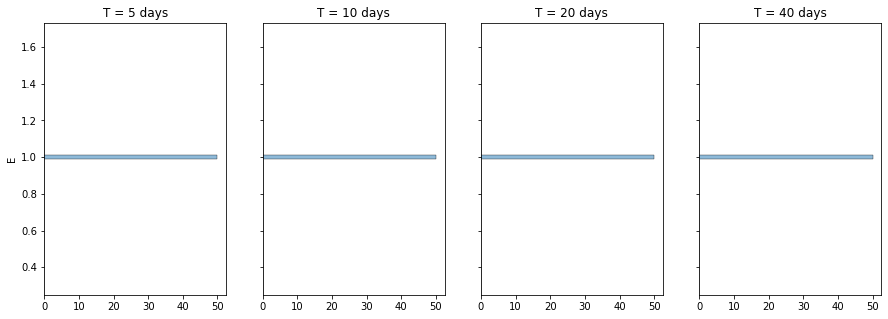

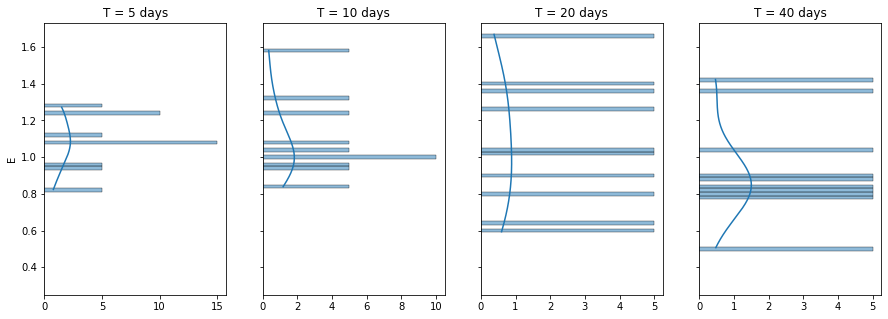

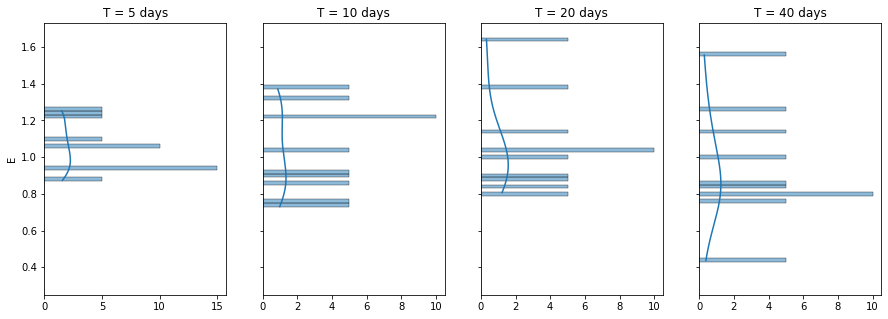

In [40]:
def add_dist(Ne, sigma0, label, color, ax):
    x0, x1 = ax.get_ylim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = E_pdf_expected(x_pdf, float(Ne), float(sigma0))
    ax.plot(y_pdf, x_pdf, color=color, lw=2, label=label)
    #ax.plot(x-y_pdf, x_pdf, color=color, lw=2, label=label)


bins = np.arange(.25, 1.75, .02)
for _sig in E.signal:
    fig, axes = plt.subplots(1, E.T.size, figsize=(15,5))

    for _T, ax in zip(E.T, axes):
        _E = E.sel(T=_T,rms=1.,signal=_sig)

        ax = sns.histplot(y=_E.M2_demodulated, stat="density", bins=bins, kde=True, ax=ax)
    #    add_dist(_E.Ne_variance, _E.u_bar_theoretical, "expected", "black", ax)
        ax.set_title(f"T = {float(_T):.0f} days")
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_ylim(bins[0], bins[-1])
        if ax!=axes[0]:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("E")

(5, 0, 48000)(5, 0, 48000) (480,)
 (480,)
(5, 0, 48000) (480,)

In [34]:
import seaborn as sns
sns.set_theme(style="whitegrid")

Playing with seaborn ...

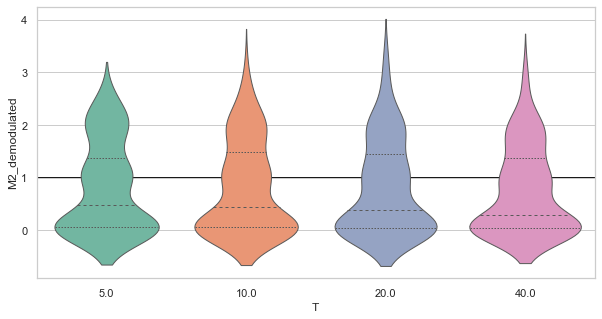

In [36]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

df = E["M2_demodulated"].to_dataframe().reset_index()
sns.violinplot(data=df, x="T", y="M2_demodulated",
               inner="quart", linewidth=1,
               palette="Set2",
               #palette={"Yes": "b", "No": ".85"})
                #label=f"T={float(_T)}"
               alpha=0.8
              )
ax = ax.axhline(1., lw=2, color="k", zorder=-1)

#sns.despine(left=True)

### Filter sensibility

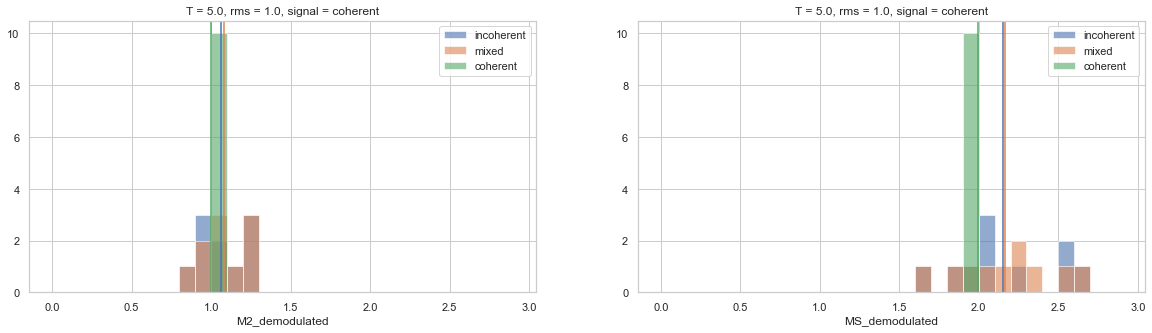

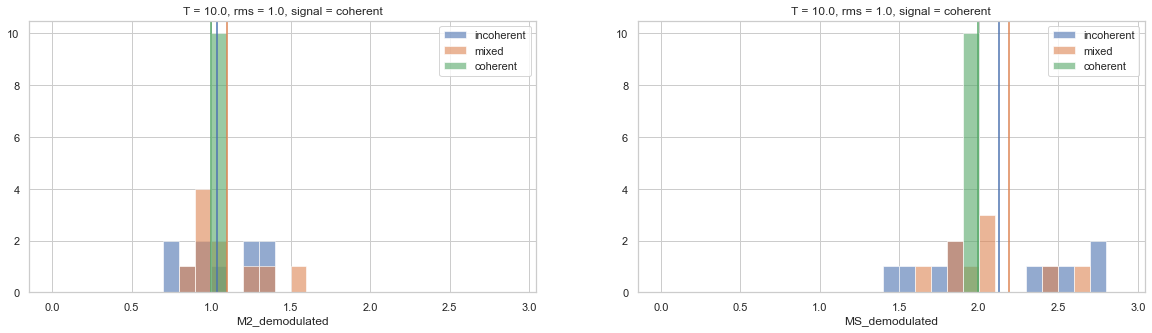

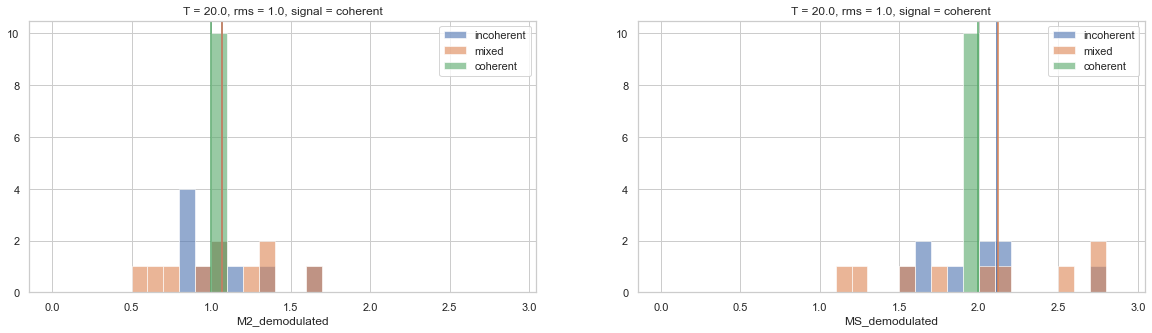

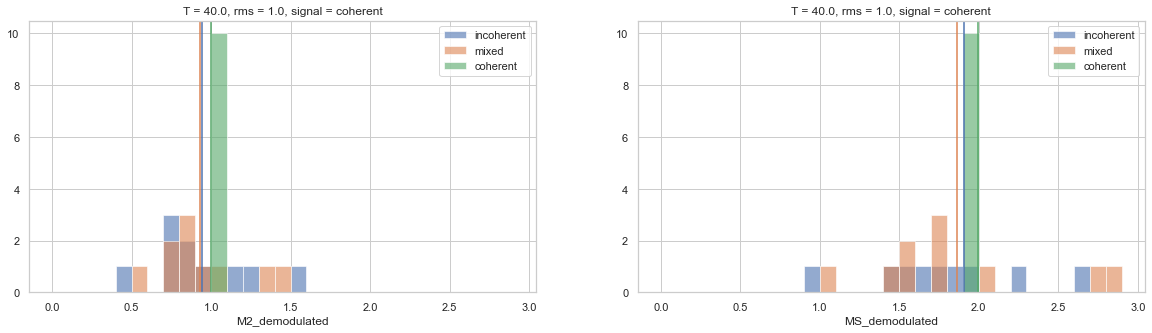

In [37]:
for T in E.T:
    fig, axs = plt.subplots(1,2, figsize=(20,5))
    bins = np.arange(0,3,.1)
    for _sig, i in zip(ds.signal[::-1],range(len(ds.signal))):
        ax = axs[0]
        _da = E["M2_demodulated"].sel(T=T,rms=1,signal=_sig)
        _da.plot.hist(bins=bins, alpha=0.6, label=_sig,ax=ax)
        ax.axvline(_da.mean(), color=f"C{i}")
        ax.legend()
        ax = axs[1]
        _da = E["MS_demodulated"].sel(T=T,rms=1,signal=_sig)
        _da.plot.hist(bins=bins, alpha=0.6, label=_sig,ax=ax)
        ax.axvline(_da.mean(), color=f"C{i}")
        ax.legend()

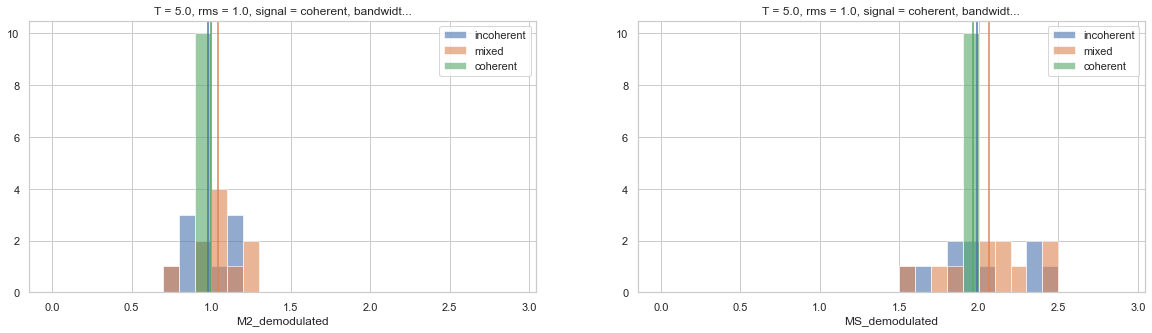

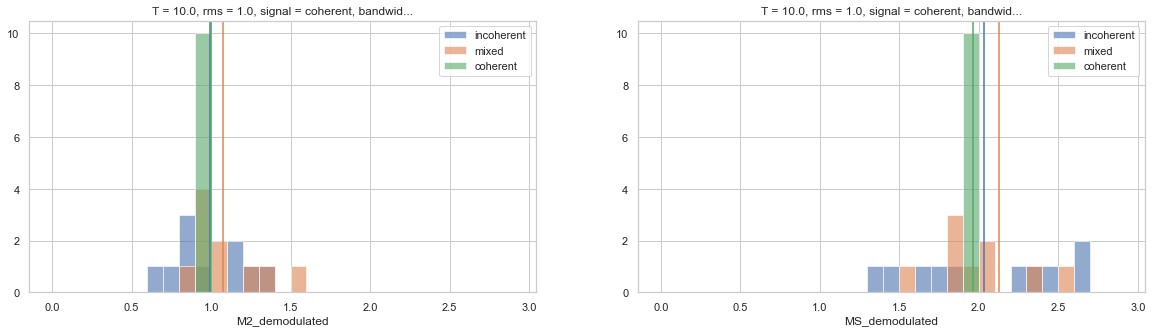

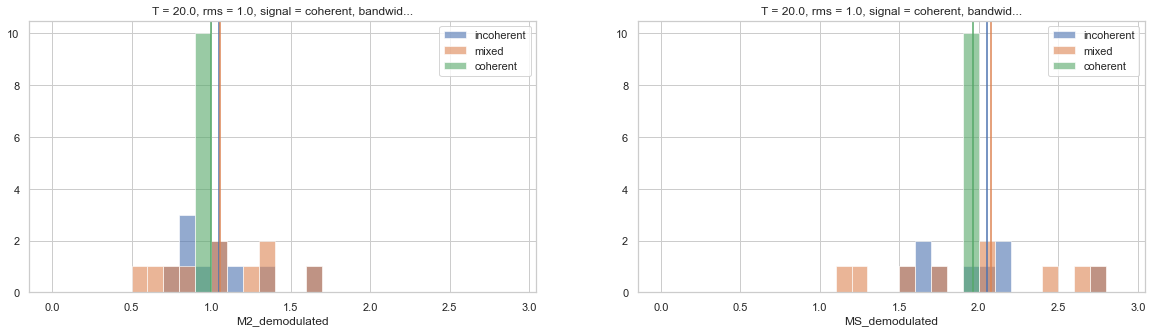

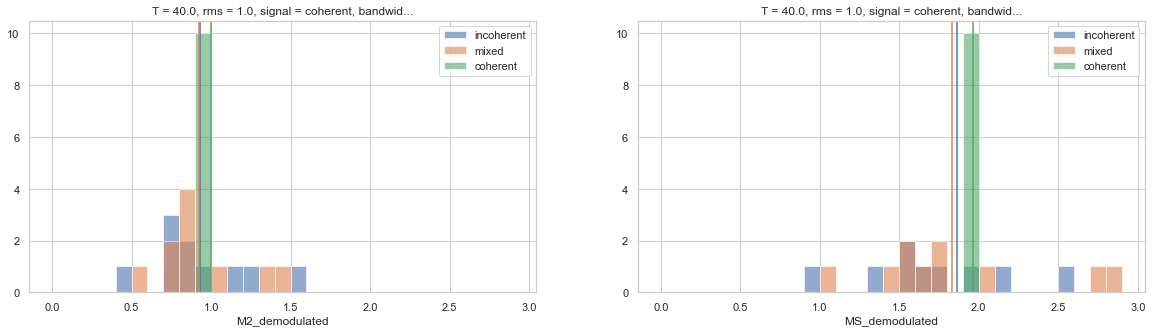

In [38]:
for T in E.T:
    fig, axs = plt.subplots(1,2, figsize=(20,5))
    bins = np.arange(0,3,.1)
    for _sig, i in zip(ds.signal[::-1],range(len(ds.signal))):
        ax = axs[0]
        _da = E_filt["M2_demodulated"].sel(T=T,rms=1,signal=_sig,bandwidth=0.6)
        _da.plot.hist(bins=bins, alpha=0.6, label=_sig,ax=ax)
        ax.axvline(_da.mean(), color=f"C{i}")
        ax.legend()
        ax = axs[1]
        _da = E_filt["MS_demodulated"].sel(T=T,rms=1,signal=_sig,bandwidth=0.6)
        _da.plot.hist(bins=bins, alpha=0.6, label=_sig,ax=ax)
        ax.axvline(_da.mean(), color=f"C{i}")
        ax.legend()

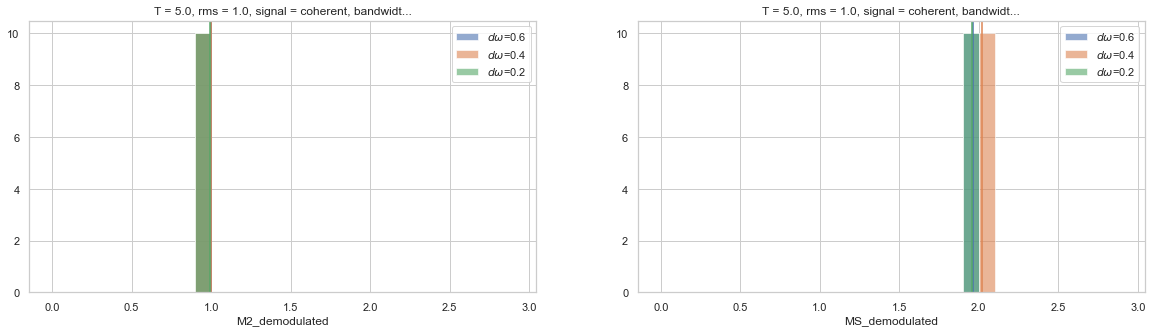

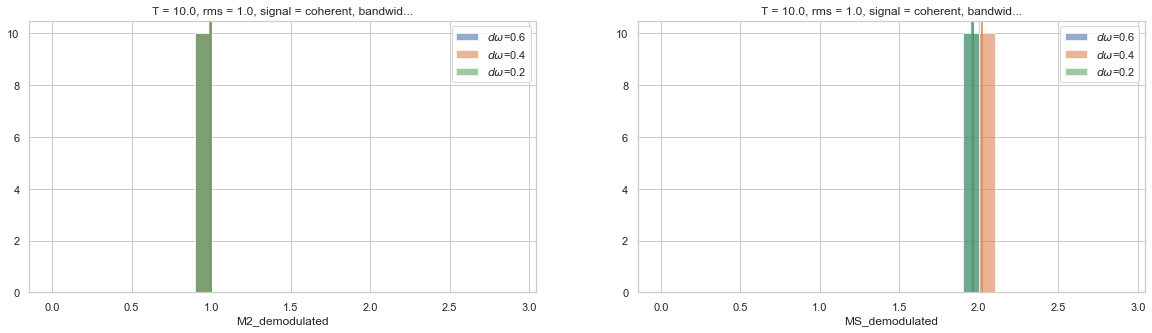

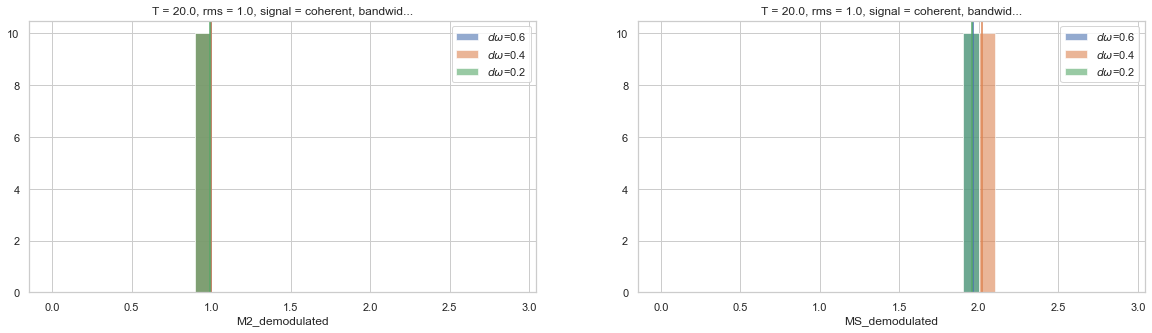

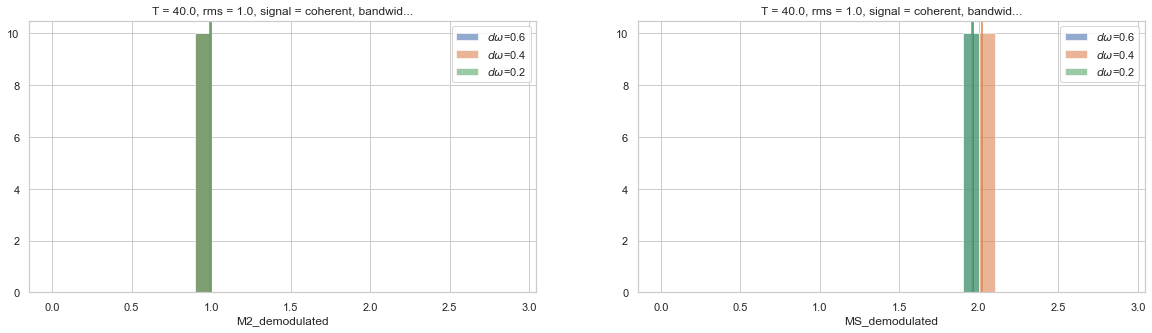

In [39]:
_sig = 'coherent'
for T in E.T:
    fig, axs = plt.subplots(1,2, figsize=(20,5))
    bins = np.arange(0,3,.1)
    for _band, i in zip(E_filt.bandwidth[::-1],range(len(E_filt.bandwidth))):
        ax = axs[0]
        _da = E_filt["M2_demodulated"].sel(T=T,rms=1,signal=_sig,bandwidth=_band)
        _da.plot.hist(bins=bins, alpha=0.6, label=r'$d\omega$=%s'%_band.values,ax=ax)
        ax.axvline(_da.mean(), color=f"C{i}")
        ax.legend()
        ax = axs[1]
        _da = E_filt["MS_demodulated"].sel(T=T,rms=1,signal=_sig,bandwidth=_band)
        _da.plot.hist(bins=bins, alpha=0.6, label=r'$d\omega$=%s'%_band.values,ax=ax)
        ax.axvline(_da.mean(), color=f"C{i}")
        ax.legend()

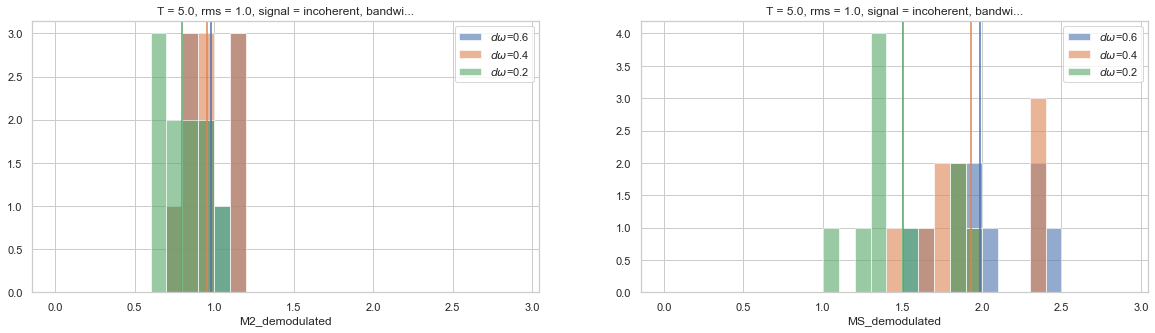

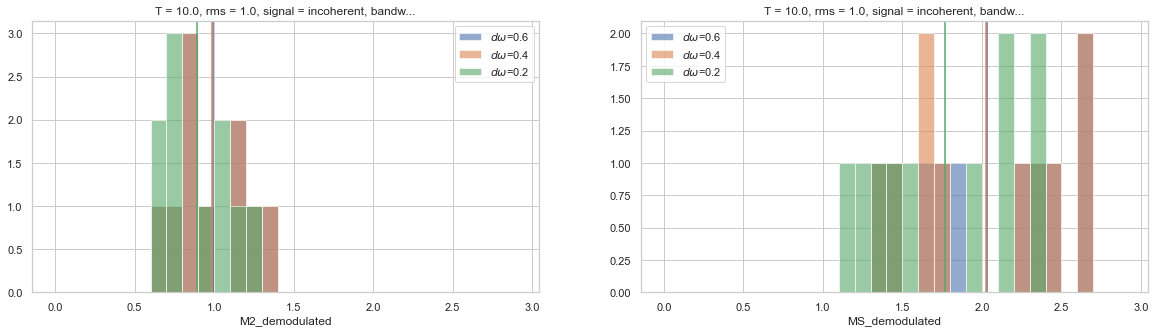

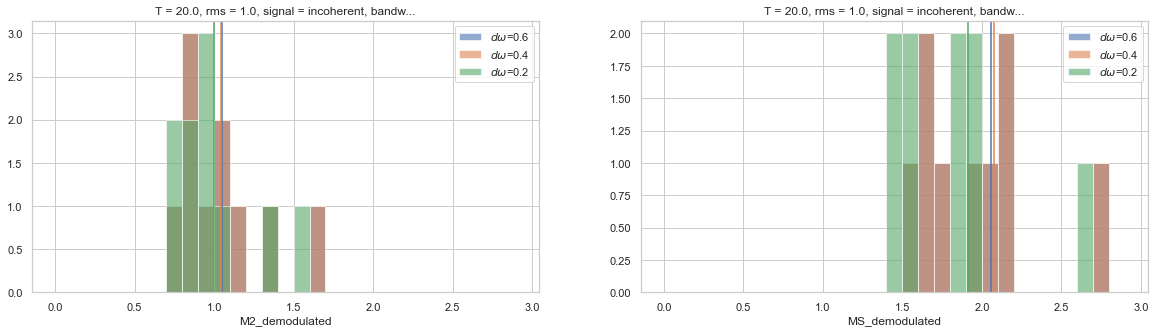

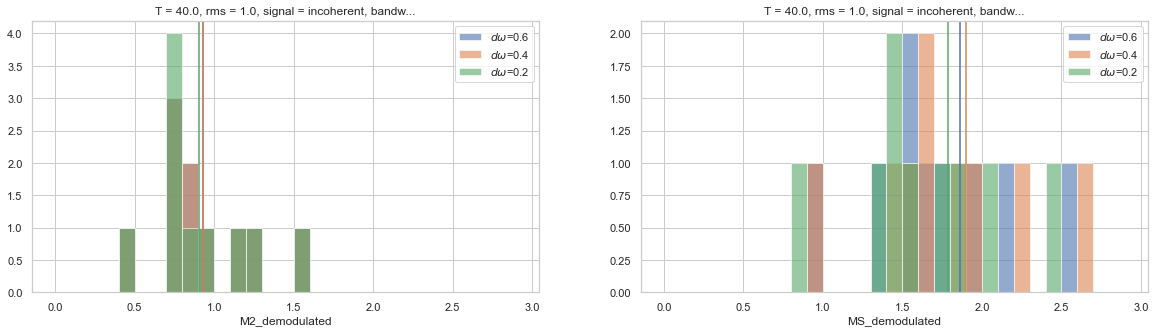

In [40]:
_sig = 'incoherent'
for T in E.T:
    fig, axs = plt.subplots(1,2, figsize=(20,5))
    bins = np.arange(0,3,.1)
    for _band, i in zip(E_filt.bandwidth[::-1],range(len(E_filt.bandwidth))):
        ax = axs[0]
        _da = E_filt["M2_demodulated"].sel(T=T,rms=1,signal=_sig,bandwidth=_band)
        _da.plot.hist(bins=bins, alpha=0.6, label=r'$d\omega$=%s'%_band.values,ax=ax)
        ax.axvline(_da.mean(), color=f"C{i}")
        ax.legend()
        ax = axs[1]
        _da = E_filt["MS_demodulated"].sel(T=T,rms=1,signal=_sig,bandwidth=_band)
        _da.plot.hist(bins=bins, alpha=0.6, label=r'$d\omega$=%s'%_band.values,ax=ax)
        ax.axvline(_da.mean(), color=f"C{i}")
        ax.legend()

In [46]:
sns.histplot?

In [53]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


ValueError: All arrays must be of the same length

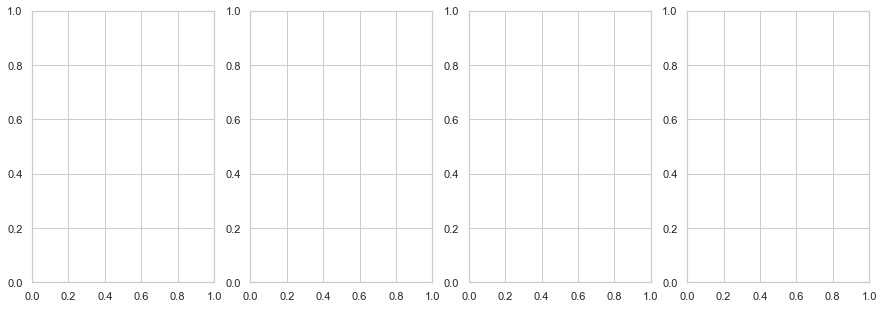

In [52]:
bins = np.arange(.25, 1.75, .02)
fig, axes = plt.subplots(1, E.T.size, figsize=(15,5))
for _T, ax in zip(E.T, axes):
    _E = E.sel(T =_T,rms=1.)
    ax = sns.histplot(y=_E.M2_demodulated.sel(signal='coherent'),hue=_E.signal, stat="density", bins=bins, kde=True, ax=ax)
#    sns.histplot(y=_E.M2_demodulated.sel(signal='coherent'), stat="density", bins=bins, kde=True, ax=ax)

---

## focus on bias and sensitivity to cutoff/decorrelation timescale ratio

A bit of theory first


In [47]:
from sympy import Symbol, pi, atan, factor, lambdify

In [23]:
u_low = hf.low_frequency_signal()

In [28]:
Symbol?

In [24]:
omegac = Symbol('omega_c', positive=True)
T_sp, U_sp = u_low.p['T'], u_low.p['U']
omega_sp, tau_sp = u_low.omega, u_low.tau

In [25]:
u_low.spectrum

2*T*U**2/(T**2*omega**2 + 1)

In [26]:
I_low = u_low.spectrum.integrate((omega_sp, 0, omegac)) *2  /2/pi
I_low = I_low.simplify()
E_low = lambdify([U_sp, T_sp, omegac], I_low)
I_low

2*U**2*atan(T*omega_c)/pi

Compare observed mean with theoretical prediction

(0.7, 1.05)

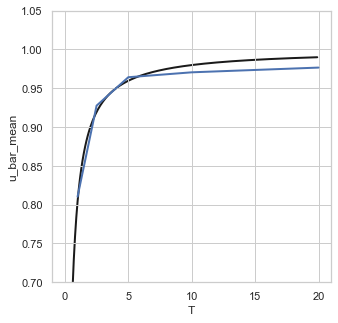

In [18]:
E["M2_demodulated_mean"] = E.M2_demodulated.mean("draw")
E["M2_demodulated_theoretical"] = E_low(np.sqrt(sigma0), ds.T, filter_cutoff*2*np.pi)

fig, ax = plt.subplots(1,1, figsize=(5,5))

#ds.E_ubar_theoretical.plot()
E.u_bar_mean.plot(lw=2)
#ds.E_ubar_mean.plot.bar()

# more finely resolved theoretical curve
_T = np.arange(0, float(ds.T.max()),.1)
_E = E_low(np.sqrt(sigma0), _T, filter_cutoff*2*np.pi)
ax.plot(_T,_E, lw=2, color="k", zorder=-1)
ax.set_ylim(.7, 1.05)

---

## focus on variance and confidence intervals

Assuming the time series are normally distributed, the energy will follow a chi square distribution (potentially non-centered):

$
\begin{align}
\frac{N x \hat E}{E}  = \chi^2(N, N \mu^2/\sigma^2)
\end{align}
$

where $N$ is the effective degrees of freedom for the variance.
So the pdf of the energy $E$ is :

$
\begin{align}
p_E(x) = \frac{N}{E} p_\chi(x\times N/E),
\end{align}
$

and the following confidence interval can be employed:

$
\begin{align}
%q_{\alpha/2} < \frac{N x \hat E}{E}  = \chi^2(N, N \mu^2/\sigma^2), \\
\hat E \times \frac{N}{q_{1-\alpha/2}} < E < \hat E \times \frac{N}{q_{\alpha/2}},
\end{align}
$

where $q_\alpha$ is the $\alpha$ percentile of the $\chi^2$ distribution.

https://fr.wikipedia.org/wiki/Loi_du_%CF%87%C2%B2_non_centr%C3%A9e
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ncx2.html

for different number of points and one timescale.

regenerate dataset

In [19]:
E_pdf_expected = lambda x, Ne, sigma0: Ne/sigma0*stats.ncx2.pdf(x*Ne/sigma0, Ne-1, Ne*mu**2/sigma0)

# compute effective degrees of freedom
N = ds.u.time.size
def compute_Ne(T):
    L = []
    for t in T:
        c = lambda tau, t=t: sigma0*np.exp(-np.abs(tau/t))
        L.append(list(sigp.effective_DOF(c, dt, N)))
    Ne_mean, Ne_variance, _ = zip(*L)
    return list(Ne_mean), list(Ne_variance)

_N = compute_Ne(E.T.values)

E["Ne_mean"] = ("T", _N[0])
E["Ne_variance"] = ("T", _N[1])

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


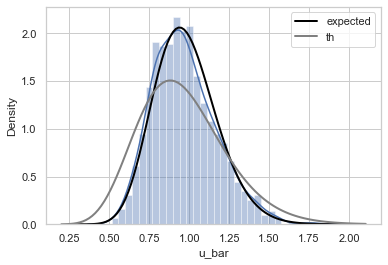

In [20]:
_E = E.sel(T=10.)

ax = sns.distplot(_E.u_bar, bins=30, norm_hist=True)

def add_dist(Ne, label, color):
    x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = E_pdf_expected(x_pdf, float(Ne), sigma0)
    ax.plot(x_pdf, y_pdf, color=color, lw=2, label=label)                                                     

add_dist(_E.Ne_variance, "expected", "black")
add_dist(_E.Ne_mean, "th", "0.5")

ax.legend()
#ax.set_ylim(0, 1.)

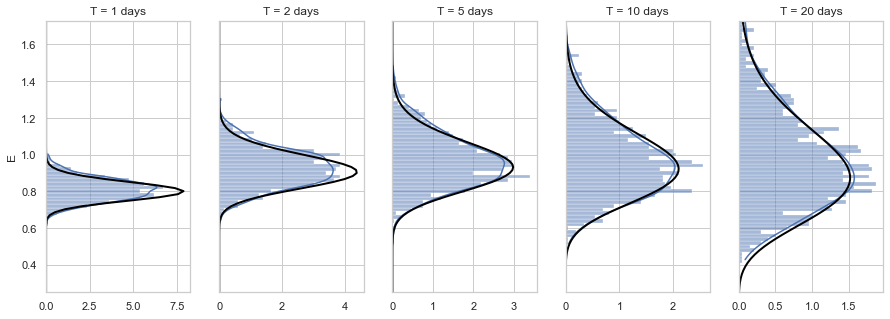

In [21]:
def add_dist(Ne, sigma0, label, color, ax):
    x0, x1 = ax.get_ylim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = E_pdf_expected(x_pdf, float(Ne), float(sigma0))
    ax.plot(y_pdf, x_pdf, color=color, lw=2, label=label)
    #ax.plot(x-y_pdf, x_pdf, color=color, lw=2, label=label)

bins = np.arange(.25, 1.75, .02)

fig, axes = plt.subplots(1, E.T.size, figsize=(15,5))

for _T, ax in zip(E.T, axes):
    _E = E.sel(T=_T)
    ax = sns.histplot(y=_E.u_bar, stat="density", bins=bins, kde=True, ax=ax)
    add_dist(_E.Ne_variance, _E.u_bar_theoretical, "expected", "black", ax)
    ax.set_title(f"T = {float(_T):.0f} days")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_ylim(bins[0], bins[-1])
    if ax!=axes[0]:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("E")

In [22]:
#stats.chi2.ppf(1-alpha/2, Ne-1)

In [23]:
alpha=0.1

#_Ne = E["Ne_mean"] # leads to an overestimate of the CI
_Ne = E["Ne_variance"] # about right
E["u_bar_low_delta"] =  _Ne/stats.ncx2.ppf(1-alpha/2, _Ne, _Ne*mu**2/E["u_bar_theoretical"])
E["u_bar_high_delta"] = _Ne /stats.ncx2.ppf(alpha/2, _Ne, _Ne*mu**2/E["u_bar_theoretical"])

Text(0.5, 1.0, 'CI hit rate')

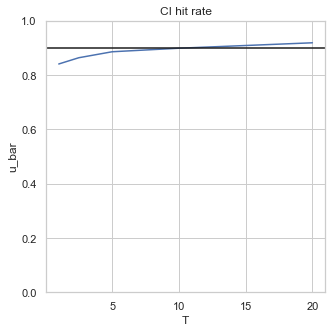

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

dum = E.u_bar.where( (E.u_bar * E.u_bar_low_delta < E.u_bar_theoretical) 
                    & (E.u_bar * E.u_bar_high_delta > E.u_bar_theoretical) 
                   )*0+1
dum = dum.fillna(0.).mean("draw")
dum.plot()
ax.axhline(1-alpha, color="k")
ax.set_ylim(0,1)
ax.set_title("CI hit rate") # i.e. number of times the true value is within the CI

---

## sensibility to subsampling

For one decorrelation timescale (10 days) and fixed data quantity (200 days), data is decimated temporally.
Statistical variablity of the energy estimate is quantified and monitored as subsampling interval is increased.


In [25]:
delta_T = 200 # time series length in days
n_draws = 10000 # number of draws
ds = generate_timeseries(delta_T, n_draws, T).persist()

In [26]:
delta = [1,6,12,24,30,24*2,24*4,24*10,24*20,24*30,24*40]
delta_days = np.array(delta)*dt

c = lambda tau: sigma0*np.exp(-np.abs(tau/T))

def get_E(ds):
    E = xr.merge( [(ds.u**2).mean("time"), (ds.u_bar**2).mean("time")])

    dt = float(ds.time[1] - ds.time[0])
    N = ds.time.size
    Ne_mean, Ne_variance, _ = sigp.effective_DOF(c, dt, N)
    
    E["Ne_mean"]  = Ne_mean
    E["Ne_variance"]  = Ne_variance

    return E

E = xr.concat([get_E(ds.isel(time=slice(0,None,d))) for d in delta], "delta")
E = E.assign_coords(delta=delta_days).compute()

E["u_bar_theoretical"] = E_low(np.sqrt(sigma0), T, filter_cutoff*2*np.pi)
E["u_bar_low"] =  (E["u_bar_theoretical"]/E.Ne_variance 
                   *stats.ncx2.ppf(alpha/2, E.Ne_variance, E.Ne_variance*mu**2/E["u_bar_theoretical"])
                  )
E["u_bar_high"] =  (E["u_bar_theoretical"]/E.Ne_variance
                   *stats.ncx2.ppf(1-alpha/2, E.Ne_variance, E.Ne_variance*mu**2/E["u_bar_theoretical"])
                   )

#E

Text(0, 0.5, 'energy')

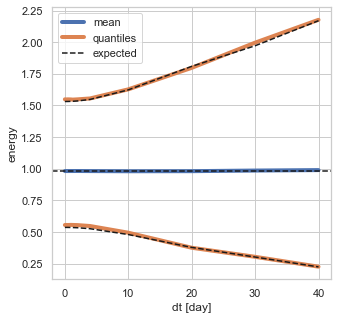

In [27]:
Eq = E.u_bar.quantile([alpha/2,1-alpha/2],"draw")

fig, ax = plt.subplots(1, 1, figsize=(5,5))

E.u_bar.mean("draw").plot(lw=4, label="mean")
Eq.isel(quantile=0).plot.line(x="delta", color="C1", lw=4, add_legend=False, label=f"quantiles")
Eq.isel(quantile=1).plot.line(x="delta", color="C1", lw=4, add_legend=False, label=None)

ax.axhline(E.u_bar_theoretical, color="k", ls="--", label="expected")
E.u_bar_low.plot(color="k", ls="--")
E.u_bar_high.plot(color="k", ls="--")

ax.legend()
ax.set_title("")
ax.set_xlabel("dt [day]")
ax.set_ylabel("energy")

For sampling interval less than a 1/10 of the decorrelation length scale, there is no substantial increase of statistical variability

---
## expected interval in quantiles in (time interval , time step) space

In [48]:
_ds = xr.Dataset(dict(alpha=np.geomspace(1e-2, 1e2, num=100), # time sampling: dt/T
                     beta=np.geomspace(2, 1e3, num=100)), # Time interval: delta_T / T
               )

_ds["dt"] = T*_ds.alpha
_ds["N"] = (T*_ds.beta/_ds.dt).astype(int)

In [51]:
_ds

<xarray.Dataset>
Dimensions:  (alpha: 100, beta: 100)
Coordinates:
  * alpha    (alpha) float64 0.01 0.01097 0.01205 0.01322 ... 83.02 91.12 100.0
  * beta     (beta) float64 2.0 2.13 2.268 2.414 ... 828.3 882.0 939.2 1e+03
    T        float64 40.0
Data variables:
    dt       (alpha) float64 0.4 0.439 0.4818 ... 3.321e+03 3.645e+03 4e+03
    N        (beta, alpha) int64 200 182 166 151 137 125 ... 15 14 13 12 10 10

In [57]:
_ds.N

<xarray.DataArray 'N' (beta: 100, alpha: 100)>
array([[   200,    182,    166, ...,      0,      0,      0],
       [   212,    194,    176, ...,      0,      0,      0],
       [   226,    206,    188, ...,      0,      0,      0],
       ...,
       [ 88201,  80365,  73226, ...,     10,      9,      8],
       [ 93915,  85572,  77970, ...,     11,     10,      9],
       [100000,  91116,  83021, ...,     12,     10,     10]])
Coordinates:
  * alpha    (alpha) float64 0.01 0.01097 0.01205 0.01322 ... 83.02 91.12 100.0
  * beta     (beta) float64 2.0 2.13 2.268 2.414 ... 828.3 882.0 939.2 1e+03
    T        float64 40.0

In [59]:
compute_Ne(_ds.dt, _ds.N)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [60]:
def effective_DOF(sigma, dt, N):
    """ Returns effective degrees of freedom (DOF) for the sample mean
    and variance along with the small sample scaling factor for variance
    References: Bailey and Hammersley 1946, Priestley chapter 5.3.2
    Parameters
    ----------
    sigma: lambda, xr.DataArray
        Autocorrelation function
    dt: float
        sampling interval
    N: int
        Timeseries length
    Returns
    -------
    mean_Ne: float
        Sample mean effective DOF
    variance_Ne: float
        Sample variance effective DOF
    variance_scale: float
        Sample variance scale correction
    """

    if isinstance(sigma, xr.DataArray):
        # transform to lambda
        assert False, "not implemented yet"

    ## sample mean
    # Priestley (5.3.5), general
    lags = np.arange(-N-1,N)
    mean_Ne = N / np.sum( ( 1-np.abs(lags)/N )*sigma(lags*dt) )

    ## sample variance
    # Priestley (5.3.23) with r=0, Gaussian assumption
    #lags = np.arange(-N-1,N)
    variance_Ne = N / np.sum( ( 1-np.abs(lags)/N ) * sigma(lags*dt)**2 )
    # small sample scaling factor - Bayley and Hammersley 1946 (10)
    variance_scale = mean_Ne * (N-1) /N /(mean_Ne-1)


In [66]:
_ds.dt


<xarray.DataArray 'dt' (alpha: 100)>
array([4.00000000e-01, 4.38999506e-01, 4.81801416e-01, 5.28776459e-01,
       5.80331511e-01, 6.36913117e-01, 6.99011360e-01, 7.67164105e-01,
       8.41961658e-01, 9.24051880e-01, 1.01414580e+00, 1.11302376e+00,
       1.22154220e+00, 1.34064106e+00, 1.47135191e+00, 1.61480690e+00,
       1.77224858e+00, 1.94504063e+00, 2.13467969e+00, 2.34280833e+00,
       2.57122925e+00, 2.82192092e+00, 3.09705473e+00, 3.39901374e+00,
       3.73041339e+00, 4.09412409e+00, 4.49329613e+00, 4.93138696e+00,
       5.41219110e+00, 5.93987305e+00, 6.51900334e+00, 7.15459812e+00,
       7.85216260e+00, 8.61773876e+00, 9.45795765e+00, 1.03800968e+01,
       1.13921435e+01, 1.25028634e+01, 1.37218771e+01, 1.50597432e+01,
       1.65280496e+01, 1.81395140e+01, 1.99080943e+01, 2.18491089e+01,
       2.39793700e+01, 2.63173290e+01, 2.88832361e+01, 3.16993159e+01,
       3.47899601e+01, 3.81819383e+01, 4.19046301e+01, 4.59902798e+01,
       5.04742753e+01, 5.53954549e+01, 6.07964433e+01, 6.67240215e+01,
       7.32295312e+01, 8.03693201e+01, 8.82052296e+01, 9.68051306e+01,
       1.06243511e+02, 1.16602123e+02, 1.27970686e+02, 1.40447669e+02,
       1.54141144e+02, 1.69169715e+02, 1.85663553e+02, 2.03765521e+02,
       2.23632407e+02, 2.45436291e+02, 2.69366026e+02, 2.95628881e+02,
       3.24452332e+02, 3.56086034e+02, 3.90803983e+02, 4.28906889e+02,
       4.70724781e+02, 5.16619866e+02, 5.66989665e+02, 6.22270458e+02,
       6.82941059e+02, 7.49526969e+02, 8.22604923e+02, 9.02807888e+02,
       9.90830542e+02, 1.08743530e+03, 1.19345890e+03, 1.30981967e+03,
       1.43752547e+03, 1.57768242e+03, 1.73150451e+03, 1.90032406e+03,
       2.08560332e+03, 2.28894706e+03, 2.51211658e+03, 2.75704484e+03,
       3.02585331e+03, 3.32087027e+03, 3.64465102e+03, 4.00000000e+03])
Coordinates:
  * alpha    (alpha) float64 0.01 0.01097 0.01205 0.01322 ... 83.02 91.12 100.0
    T        float64 40.0

In [69]:
cluster.close()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/

In [67]:
c = lambda tau: sigma0*np.exp(-np.abs(tau/T))

def compute_Ne(dt, N, estimate="variance"):
#    if np.isnan(N):
#        return np.NaN
    Ne_mean, Ne_variance, _ = sigp.effective_DOF(c, dt, N)
    if estimate=="variance":
        return Ne_variance
    elif estimate=="mean":
        return Ne_mean
    
_ds["Ne"] = xr.apply_ufunc(compute_Ne, _ds.dt, _ds.N, vectorize=True,input_core_dims=[["alpha"],["alpha","beta"]])

_ds["low"] = 1/_ds.Ne*stats.ncx2.ppf(alpha/2, _ds.Ne, _ds.Ne*mu**2/1)
_ds["high"] = 1/_ds.Ne*stats.ncx2.ppf(1-alpha/2, _ds.Ne, _ds.Ne*mu**2/1)    

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

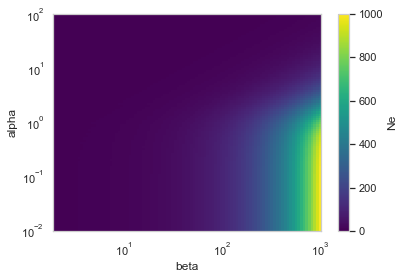

In [30]:
fig, ax = plt.subplots(1,1)
ds["Ne"].plot()
ax.set_xscale("log")
ax.set_yscale("log")

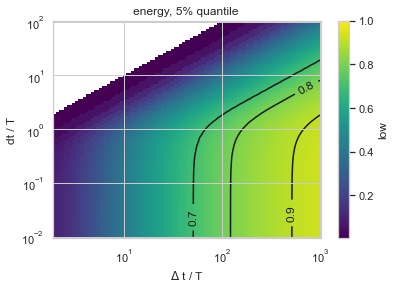

In [ ]:
def plot_stat(da, levels, title, **kwargs):

    fig, ax = plt.subplots(1,1)
    da.plot(zorder=-1, **kwargs)

    ax.set_xscale("log")
    ax.set_yscale("log")

    CS = da.plot.contour(levels=levels, colors="k", zorder=-1)
    ax.clabel(CS, inline=True)
    ax.set_xlabel(r"$\Delta$ t / T")
    ax.set_ylabel("dt / T")

    ax.grid()
    ax.set_title(title)
    
plot_stat(ds["low"], [0.7, 0.8, 0.9], f"energy, {alpha/2*100:.0f}% quantile ", vmax=1)
plot_stat(ds["high"], [1.1, 1.2, 1.3], f"energy, {(1-alpha/2)*100:.0f}% quantile ", vmin=1, cmap="viridis_r")